## Soccer Results Prediction - Poisson Model

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn
from scipy.stats import poisson,skellam

In [2]:
epl_1617 = pd.read_csv("http://www.football-data.co.uk/mmz4281/1617/E0.csv")
epl_1617 = epl_1617[['HomeTeam','AwayTeam','FTHG','FTAG', 'FTR']]
epl_1617 = epl_1617.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals' , 'FTR' : 'Winner'})
epl_1617.head()

,HomeTeam,AwayTeam,HomeGoals,AwayGoals,Winner
0,Burnley,Swansea,0,1,A
1,Crystal Palace,West Brom,0,1,A
2,Everton,Tottenham,1,1,D
3,Hull,Leicester,2,1,H
4,Man City,Sunderland,2,1,H


We use all the games from season 16/17 until the last 10 games to the model and we will predict the last 10 games.

In [212]:
epl_1617 = epl_1617[:-10]
print(epl_1617.mean())

HomeGoals    1.636364
AwayGoals    1.187879
dtype: float64


## Poisson Distribution

- discrete probability distribution
- describes probability of number of events within a time period
- known mean $ \lambda > 0$
- number of events is independent of time
- probability of one event in a short interval $ h $ where $ h = \frac{1}{n} $ is approximately $ \lambda h = \frac{\lambda}{n} $
- probability of two ore more events in a short interval is essentially zero


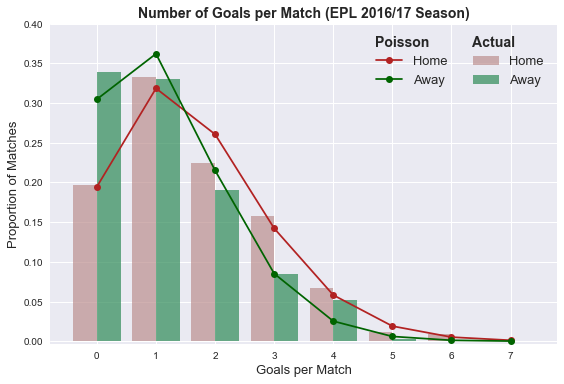

In [244]:
# creat Poisson value for each mean goals value
poisson_pred = np.column_stack([[poisson.pmf(i, epl_1617.mean()[j]) for i in range(8)] for j in range(2)])

# histogram of actual goals
plt.hist(epl_1617[['HomeGoals', 'AwayGoals']].values, range(9), 
         alpha=0.7, label=['Home', 'Away'],normed=True, color=["rosybrown", "seagreen"])

# plot Poisson
pois1, = plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,0],
                  linestyle='-', marker='o',label="Home", color = 'firebrick')
pois2, = plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,1],
                  linestyle='-', marker='o',label="Away", color = 'darkgreen')

leg=plt.legend(loc='upper right', fontsize=13, ncol=2)
leg.set_title("Poisson           Actual        ", prop = {'size':'14', 'weight':'bold'})

plt.xticks([i-0.5 for i in range(1,9)],[i for i in range(9)])
plt.xlabel("Goals per Match",size=13)
plt.ylabel("Proportion of Matches",size=13)
plt.title("Number of Goals per Match (EPL 2016/17 Season)",size=14,fontweight='bold')
plt.ylim([-0.004, 0.4])
plt.tight_layout()
plt.show()


Probability of home team scoring more than 2 goals:

$ P(\geq2|Home) = P(2|Home) + P(3|Home) + ... $

$ P(\geq2|Home) = 0.258 + 0.137 + ... $

$ P(\geq2|Home) = 0.47 $

$ $

Probability of a draw:

$ P(Home=Away) = P(0|Home) * P(0|Away) + P(1|Home) * P(1|Away) + ... $

$ P(Home=Away) = 0.203 * 0.306 + 0.324 * 0.362 + ... $

$ P(Home=Away) = 0.248 $

In [4]:
# probability of draw between home and away team
skellam.pmf(0.0,  epl_1617.mean()[0],  epl_1617.mean()[1])

0.24809376810717076

In [5]:
# probability of home team winning by one goal
skellam.pmf(1,  epl_1617.mean()[0],  epl_1617.mean()[1])

0.22706765807563964

In [6]:
# probability of home team winning by two goals
skellam.pmf(2,  epl_1617.mean()[0],  epl_1617.mean()[1])

0.14180866650031265

Since we are assuming that the number of goals scored by each team are independent events, each event has its own Poisson distribution. The difference of two Poisson distributions is a Skellam distribution.

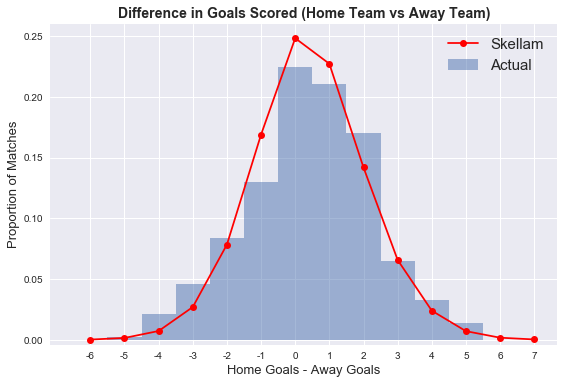

In [7]:
skellam_pred = [skellam.pmf(i,  epl_1617.mean()[0],  epl_1617.mean()[1]) for i in range(-6,8)]

plt.hist(epl_1617[['HomeGoals']].values - epl_1617[['AwayGoals']].values, range(-6,8), 
         alpha=0.5, label='Actual',normed=True)
plt.plot([i+0.5 for i in range(-6,8)], skellam_pred,
                  linestyle='-', marker='o',label="Skellam", color = 'r')
plt.legend(loc='upper right', fontsize=15)
plt.xticks([i+0.5 for i in range(-6,8)],[i for i in range(-6,8)])
plt.xlabel("Home Goals - Away Goals",size=13)
plt.ylabel("Proportion of Matches",size=13)
plt.title("Difference in Goals Scored (Home Team vs Away Team)",size=14,fontweight='bold')
plt.ylim([-0.004, 0.26])
plt.tight_layout()
plt.show()

The way this works is that we have to figure out the average goals scored by each team and feed this into the Poisson model. We assume that the number of goals scored by each team is Poisson distributed. To show that we can model the goals scored in season 16/17 by two teams in this case Chelsea and Sunderland. We seperate the data into goals scored home and away.

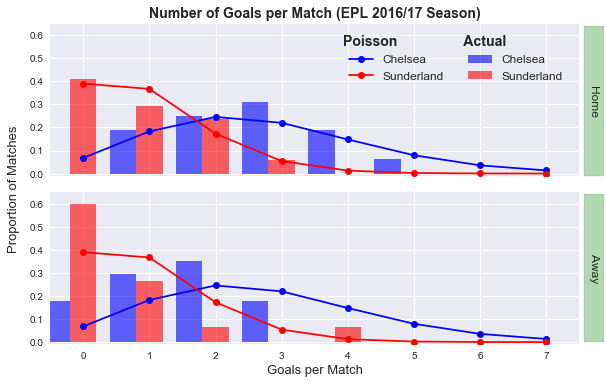

In [240]:
fig,(ax1,ax2) = plt.subplots(2, 1)


chel_home = epl_1617[epl_1617['HomeTeam']=='Chelsea'][['HomeGoals']].apply(pd.value_counts,normalize=True)
chel_home_pois = [poisson.pmf(i,np.sum(np.multiply(chel_home.values.T,chel_home.index.T),axis=1)[0]) for i in range(8)]
sun_home = epl_1617[epl_1617['HomeTeam']=='Sunderland'][['HomeGoals']].apply(pd.value_counts,normalize=True)
sun_home_pois = [poisson.pmf(i,np.sum(np.multiply(sun_home.values.T,sun_home.index.T),axis=1)[0]) for i in range(8)]

chel_away = epl_1617[epl_1617['AwayTeam']=='Chelsea'][['AwayGoals']].apply(pd.value_counts,normalize=True)
chel_away_pois = [poisson.pmf(i,np.sum(np.multiply(chel_home.values.T,chel_home.index.T),axis=1)[0]) for i in range(8)]
sun_away = epl_1617[epl_1617['AwayTeam']=='Sunderland'][['AwayGoals']].apply(pd.value_counts,normalize=True)
sun_away_pois = [poisson.pmf(i,np.sum(np.multiply(sun_home.values.T,sun_home.index.T),axis=1)[0]) for i in range(8)]

ax1.bar(chel_home.index-0.4,chel_home.values,width=0.4,color="b",label="Chelsea",alpha=0.6)
ax1.bar(sun_home.index,sun_home.values,width=0.4,color="r",label="Sunderland",alpha=0.6)
pois1, = ax1.plot([i for i in range(8)], chel_home_pois,
                  linestyle='-', marker='o',label="Chelsea", color = "b")
pois1, = ax1.plot([i for i in range(8)], sun_home_pois,
                  linestyle='-', marker='o',label="Sunderland", color = "r")
leg=ax1.legend(loc='upper right', fontsize=12, ncol=2)
leg.set_title("Poisson                 Actual                ", prop = {'size':'14', 'weight':'bold'})
ax1.set_xlim([-0.5,7.5])
ax1.set_ylim([-0.01,0.65])
ax1.set_xticklabels([])
ax1.text(7.65, 0.585, '                Home                ', rotation=-90,
        bbox={'facecolor':'g', 'alpha':0.3, 'pad':5})
ax2.text(7.65, 0.585, '                Away                ', rotation=-90,
        bbox={'facecolor':'g', 'alpha':0.3, 'pad':5})

ax2.bar(chel_away.index-0.4,chel_away.values,width=0.4,color="b",label="Chelsea",alpha=0.6)
ax2.bar(sun_away.index,sun_away.values,width=0.4,color="r",label="Sunderland",alpha=0.6)
pois1, = ax2.plot([i for i in range(8)], chel_away_pois,
                  linestyle='-', marker='o',label="Chelsea", color = "b")
pois1, = ax2.plot([i for i in range(8)], sun_away_pois,
                  linestyle='-', marker='o',label="Sunderland", color = "r")
ax2.set_xlim([-0.5,7.5])
ax2.set_ylim([-0.01,0.65])
ax1.set_title("Number of Goals per Match (EPL 2016/17 Season)",size=14,fontweight='bold')
ax2.set_xlabel("Goals per Match",size=13)
ax2.text(-1.15, 0.9, 'Proportion of Matches', rotation=90, size=13)
plt.tight_layout()
plt.show()

The graph above proves our assumption that the goals scored by a team are roughly Poisson distributed. 

## The model

- using GLM (Generalized Linear Models) because we can't assume that the data is normally distributed
- chose Poison Regression because:
    - response variable is number of occurances in given time frame
    - Poisson distribution of goal data


In [9]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [10]:
goal_model_data = pd.concat([epl_1617[['HomeTeam','AwayTeam','HomeGoals']].assign(home=1).rename(
            columns={'HomeTeam':'team', 'AwayTeam':'opponent','HomeGoals':'goals'}),
           epl_1617[['AwayTeam','HomeTeam','AwayGoals']].assign(home=0).rename(
            columns={'AwayTeam':'team', 'HomeTeam':'opponent','AwayGoals':'goals'})])

poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data, 
                        family=sm.families.Poisson()).fit()
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                  740
Model:                            GLM   Df Residuals:                      700
Model Family:                 Poisson   Df Model:                           39
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -1042.4
Date:                Tue, 21 Nov 2017   Deviance:                       776.11
Time:                        21:29:32   Pearson chi2:                     659.
No. Iterations:                     5                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.3725      0.198      1.880      0.060      -0.016       0.761
team[T.Bournemouth]           -0.2891      0.179     -1.612      0.107      -0.641       0.062
team[T.Burnley]               -0.6458      0.200     -3.230      0.001      -1.038      -0.254
team[T.Chelsea]                0.0789      0.162      0.488      0.626      -0.238       0.396
team[T.Crystal Palace]        -0.3865      0.183     -2.107      0.035      -0.746      -0.027
team[T.Everton]               -0.2008      0.173     -1.161      0.246      -0.540       0.138
team[T.Hull]                  -0.7006      0.204     -3.441      0.001      -1.100      -0.302
team[T.Leicester]             -0.4204      0.187     -2.249      0.025      -0.787      -0.054
team[T.Liverpool]              0.0162      0.164      0.099      0.921      -0.306       0.338
team[T.Man City]               0.0117      0.164      0.072      0.943      -0.310       0.334
team[T.Man United]            -0.3572      0.181     -1.971      0.049      -0.713      -0.002
team[T.Middlesbrough]         -1.0087      0.225     -4.481      0.000      -1.450      -0.568
team[T.Southampton]           -0.5804      0.195     -2.976      0.003      -0.963      -0.198
team[T.Stoke]                 -0.6082      0.197     -3.094      0.002      -0.994      -0.223
team[T.Sunderland]            -0.9619      0.222     -4.329      0.000      -1.397      -0.526
team[T.Swansea]               -0.5136      0.192     -2.673      0.008      -0.890      -0.137
team[T.Tottenham]              0.0532      0.162      0.328      0.743      -0.265       0.371
team[T.Watford]               -0.5969      0.197     -3.035      0.002      -0.982      -0.211
team[T.West Brom]             -0.5567      0.194     -2.876      0.004      -0.936      -0.177
team[T.West Ham]              -0.4802      0.189     -2.535      0.011      -0.851      -0.109
opponent[T.Bournemouth]        0.4109      0.196      2.092      0.036       0.026       0.796
opponent[T.Burnley]            0.1657      0.206      0.806      0.420      -0.237       0.569
opponent[T.Chelsea]           -0.3036      0.234     -1.298      0.194      -0.762       0.155
opponent[T.Crystal Palace]     0.3287      0.200      1.647      0.100      -0.062       0.720
opponent[T.Everton]           -0.0442      0.218     -0.202      0.840      -0.472       0.384
opponent[T.Hull]               0.4979      0.193      2.585      0.010       0.120       0.875
opponent[T.Leicester]          0.3369      0.199      1.694      0.090      -0.053       0.727
opponent[T.Liverpool]         -0.0374      0.217     -0.172      0.863      -0.463       0.389
opponent[T.Man City]          -0.0993      0.222     -0.448      0.654      -0.534       0.335
opponent[T.Man United]        -0.4220      0.241     -1.754      0.079      -0.894       0.050
opponent[T.Middlesbrough]  

Considering the table above the most interesting aspect is the coefficient (exponent of the parameter values) column, which corresponds to the slope of the linear regression. This means a value close to 0 has almost no effect ( $ e^0 = 1 $). The last row shows the home team coefficient of 0.2969, which means that the home team on average scores more goals than the away team (home team is $ e^{0.2969} = 1.35 $ time more likely to score a goal).  When we compare two teams for example Chelsea (0.0789) and Sunderland (-0.9619) the coefficient value tells us that Chalsea scores more goals than the average while Sunderland scores less goals than the average. 

The second half ot the table shows the opponent* values. Those values either penalize or reward a team. Those vales include the defensive strenght of a team in our model. If a team plays against Chelsea for example it will get penalized by 0.3036.

In order to predict a game we first have to calculate the expected average number of goals scored by each team considering the opponents defensive strength. In this case the next Chelsea game in 16/17 is against Sunderland.

In [11]:
poisson_model.predict(pd.DataFrame(data={'team': 'Chelsea', 'opponent': 'Sunderland',
                                       'home':1},index=[1]))

1    3.061662
dtype: float64

In [12]:
poisson_model.predict(pd.DataFrame(data={'team': 'Sunderland', 'opponent': 'Chelsea',
                                       'home':0},index=[1]))

1    0.409373
dtype: float64

We can now use those two Poisson distributions to predict multiple scores of the game. For visulization reasons we choose every possible score with max. 3 goals for each team.

In [13]:
def simulate_match(foot_model, homeTeam, awayTeam, max_goals=10):
    home_goals_avg = foot_model.predict(pd.DataFrame(data={'team': homeTeam, 
                                                            'opponent': awayTeam,'home':1},
                                                      index=[1])).values[0]
    away_goals_avg = foot_model.predict(pd.DataFrame(data={'team': awayTeam, 
                                                            'opponent': homeTeam,'home':0},
                                                      index=[1])).values[0]
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [home_goals_avg, away_goals_avg]]
    
    return(np.outer(np.array(team_pred[0]), np.array(team_pred[1])))

In [14]:
simulate_match(poisson_model, 'Chelsea', 'Sunderland', max_goals=3)

array([[ 0.03108485,  0.01272529,  0.00260469,  0.00035543],
       [ 0.0951713 ,  0.03896054,  0.00797469,  0.00108821],
       [ 0.14569118,  0.059642  ,  0.01220791,  0.00166586],
       [ 0.14868571,  0.06086788,  0.01245883,  0.0017001 ]])

The diagonal (left top to right bottom) is the probability of all draws starting with 0:0 in the top left corner. All the probabilities of wins for chelesa are loacted in the bottom left trilangular matrix while Sunderlands wins are located in the top right. The matrix is organized in the following way considering Chelese goals:Sunderland goals 

$$ \begin{bmatrix} 0:0 & 0:1 & 0:2 & 0:3 \\
1:0 & 1:1 & 1:2 & 1:3 \\
2:0 & 2:1 & 2:2 & 2:3 \\
3:0 & 3:1 & 3:2 & 3:3 \end{bmatrix} $$

To predict the probabilities of win, draw, and loss from chelseas perspective you can just sum up the values of lover triangel, diagonal, upper triangle respectively.

In [15]:
chel_sun = simulate_match(poisson_model, "Chelsea", "Sunderland", max_goals=10)

In [16]:
# chelsea win
np.sum(np.tril(chel_sun, -1))

0.88859866123641451

In [17]:
# draw
np.sum(np.diag(chel_sun))

0.084093492686495269

In [18]:
# sunderland win
np.sum(np.triu(chel_sun, 1))

0.026961819942852801

## Predicting games without certainty limit

In [277]:
def simulate0(season, x):
    
    epl = pd.read_csv("http://www.football-data.co.uk/mmz4281/{}/E0.csv".format(season))
    epl = epl[['HomeTeam','AwayTeam','FTHG','FTAG', 'FTR', 'B365H', 'B365A','B365D']]
    epl = epl.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals' , 'FTR' : 'Winner'})
    goal_model_data = pd.concat([epl[['HomeTeam','AwayTeam','HomeGoals']].assign(home=1).rename(
            columns={'HomeTeam':'team', 'AwayTeam':'opponent','HomeGoals':'goals'}),
           epl[['AwayTeam','HomeTeam','AwayGoals']].assign(home=0).rename(
            columns={'AwayTeam':'team', 'HomeTeam':'opponent','AwayGoals':'goals'})])

    poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data, 
                            family=sm.families.Poisson()).fit()
    
    epl_matches = epl[['HomeTeam','AwayTeam']]
    epl_matches = epl_matches[-10:]
    epl_winner = epl[['Winner']]
    epl_odds = epl[['B365H', 'B365A', 'B365D']]

    #model lists
    bets = []
    results = []
    odds = []
    
    #bookies litst
    bookies_bets = []
    bookies_results = []
    bookies_odds = []
    
    #initial values
    payout = 0
    bookies_payout = 0
    model_wins = 0
    bookies_wins = 0
    
    for i in range(371,380):
        matrix = simulate_match(poisson_model, epl_matches['HomeTeam'][i], epl_matches['AwayTeam'][i], max_goals=10)
        home_win = np.sum(np.tril(matrix, -1))
        draw = np.sum(np.diag(matrix))
        away_win = np.sum(np.triu(matrix, 1))
        
        if home_win > away_win and home_win > draw:
            bets.append('H')
            results.append(epl_winner['Winner'][i])
            odds.append((float)(epl_odds['B365H'][i]))
        elif away_win > home_win and away_win > draw:
            bets.append('A')
            results.append(epl_winner['Winner'][i])
            odds.append((float)(epl_odds['B365A'][i]))
        elif draw > home_win and draw > away_win:
            bets.append('D')
            results.append(epl_winner['Winner'][i])
            odds.append((float)(epl_odds['B365D'][i]))
            
        if 1/epl_odds['B365H'][i] > 1/epl_odds['B365A'][i] and 1/epl_odds['B365H'][i] > 1/epl_odds['B365D'][i]:
            bookies_bets.append('H')
            bookies_results.append(epl_winner['Winner'][i])
            bookies_odds.append((float)(epl_odds['B365H'][i]))
        elif 1/epl_odds['B365A'][i] > 1/epl_odds['B365H'][i] and 1/epl_odds['B365A'][i] > 1/epl_odds['B365D'][i]:
            bookies_bets.append('A')
            bookies_results.append(epl_winner['Winner'][i])
            bookies_odds.append((float)(epl_odds['B365A'][i]))
        elif 1/epl_odds['B365D'][i] > 1/epl_odds['B365H'][i] and 1/epl_odds['B365D'][i] > 1/epl_odds['B365A'][i]:
            bookies_bets.append('D')
            bookies_results.append(epl_winner['Winner'][i])
            bookies_odds.append((float)(epl_odds['B365D'][i]))

            
    model_acc = 0
    bookies_acc = 0
    
    for k in range(0, len(bets)):
        if bets[k] == results[k]:
            payout += (odds[k]*(x/len(bets)))
            model_acc += 1
        else:
            payout -= x/len(bets)
            
    for m in range(0, len(bookies_bets)):       
        if bookies_bets[m] == bookies_results[m]:
            bookies_payout += (bookies_odds[m]*(x/len(bookies_bets)))
            bookies_acc += 1
        else:
            bookies_payout -= x/len(bookies_bets)
    
    print()
    print(season)
    print("Model bets: {}".format(bets))
    print("Actual results: {}".format(results))
    print("Model accuracy: {}%".format((model_acc*100)/len(bets)))
    print()
    
    print("Bookies results: {}".format(bookies_bets))
    print("Bookies results: {}".format(bookies_results))
    print("Bookies accuracy: {}%".format((bookies_acc*100)/len(bookies_bets)))
    
    return [payout, bookies_payout]


0708
Model bets: ['H', 'A', 'H', 'H', 'H', 'A', 'A', 'A', 'A']
Actual results: ['D', 'A', 'H', 'H', 'A', 'A', 'A', 'D', 'A']
Model accuracy: 66.66666666666667%

Bookies results: ['H', 'A', 'H', 'H', 'A', 'A', 'A', 'A']
Bookies results: ['D', 'A', 'H', 'H', 'A', 'A', 'D', 'A']
Bookies accuracy: 75.0%

0809
Model bets: ['H', 'H', 'H', 'A', 'H', 'H', 'A', 'H', 'H']
Actual results: ['H', 'D', 'A', 'A', 'H', 'H', 'A', 'H', 'H']
Model accuracy: 77.77777777777777%

Bookies results: ['H', 'H', 'H', 'A', 'H', 'H', 'A', 'H', 'H']
Bookies results: ['H', 'D', 'A', 'A', 'H', 'H', 'A', 'H', 'H']
Bookies accuracy: 77.77777777777777%

0910
Model bets: ['H', 'H', 'A', 'H', 'H', 'A', 'H', 'A', 'H']
Actual results: ['A', 'H', 'H', 'H', 'H', 'D', 'H', 'D', 'H']
Model accuracy: 55.55555555555556%

Bookies results: ['H', 'H', 'A', 'H', 'H', 'A', 'H', 'A', 'H']
Bookies results: ['A', 'H', 'H', 'H', 'H', 'D', 'H', 'D', 'H']
Bookies accuracy: 55.55555555555556%

1011
Model bets: ['A', 'A', 'A', 'H', 'H', 'H',

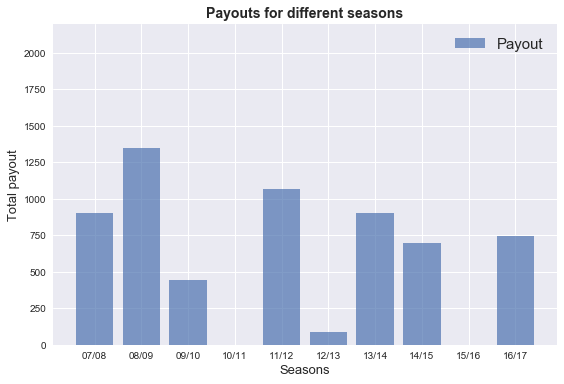

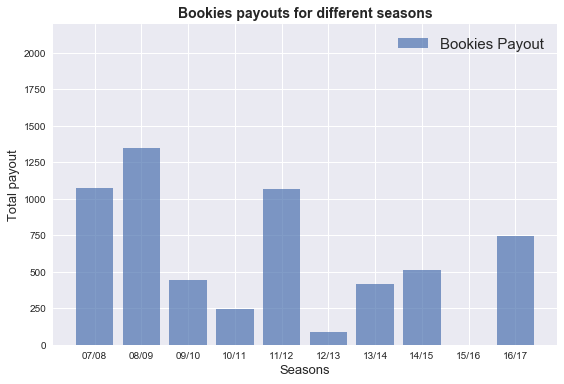

In [278]:
payouts = []
bookies_payouts = []
x = 1000

for i in range(708,1718,101):
    if i < 1011:
        simu = simulate0('0'+str(i),x)
        payouts.append(simu[0])
        bookies_payouts.append(simu[1])
    else:
        simu = simulate0(str(i),x)
        payouts.append(simu[0])
        bookies_payouts.append(simu[1])

print()
print("Total payout over 10 seasons is: {}".format(np.sum(payouts)-(x*len(payouts))))
print("This is {}%".format(((np.sum(payouts)-(x*len(payouts)))*100)/(x*len(payouts))))
print()
print("Total bookies payout over 10 seasons is: {}".format(np.sum(bookies_payouts)-(x*len(bookies_payouts))))
print("This is {}%".format(((np.sum(bookies_payouts)-(x*len(bookies_payouts)))*100)/(x*len(bookies_payouts))))

x = np.arange(10)
plt.bar(x, height= payouts, label='Payout', alpha=0.7)
plt.xticks(x, ['07/08','08/09','09/10','10/11','11/12','12/13','13/14','14/15','15/16','16/17']);
plt.legend(loc='upper right', fontsize=15)
plt.xlabel("Seasons",size=13)
plt.ylabel("Total payout",size=13)
plt.title("Payouts for different seasons",size=14,fontweight='bold')
plt.tight_layout()
plt.ylim(0,2200)
plt.show()

x = np.arange(10)
plt.bar(x, height= bookies_payouts, label='Bookies Payout', alpha=0.7)
plt.xticks(x, ['07/08','08/09','09/10','10/11','11/12','12/13','13/14','14/15','15/16','16/17']);
plt.legend(loc='upper right', fontsize=15)
plt.xlabel("Seasons",size=13)
plt.ylabel("Total payout",size=13)
plt.title("Bookies payouts for different seasons",size=14,fontweight='bold')
plt.tight_layout()
plt.ylim(0,2200)
plt.show()

## Accuracy Comparison:

Model mean accuracy: $ \frac{66.67+77.78+55.56+33.33+77.78+44.44+66.67+55.56+33.33+66.67)}{10} = 57.78\% $


Model total accuracy $ = \frac{\text{# of correct bets}*100}{\text{# of total bets}} =  \frac{52*100}{90}=57.78\% $


Bookies mean accuracy: $ \frac{(75+77.78+55.56+44.44+77.78+44.44+55.56+55.56+33.33+66.67)}{10}= 58.61\% $

Bookies total accuracy $ = \frac{\text{# of correct bets}*100}{\text{# of total bets}} =  \frac{52*100}{89}=58.42\% $

In season 07/08 the odds of a win of the home team were equal the odds of a win of the away team thats why the bookies didn't bet on that one game.

## Prediction and betting simulation for last 10 games of different seasons including certainty limit

For this simulation I will bet every time the away of home team wins with a probability P > 0.55. The simulation will assume that we bet the same part of x dollars on each game. In the following 3 simulation the bookies will only bet if they predict a winner by at least 55%

In [268]:
def simulate(season, x):
    
    epl = pd.read_csv("http://www.football-data.co.uk/mmz4281/{}/E0.csv".format(season))
    epl = epl[['HomeTeam','AwayTeam','FTHG','FTAG', 'FTR', 'B365H', 'B365A']]
    epl = epl.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals' , 'FTR' : 'Winner'})
    goal_model_data = pd.concat([epl[['HomeTeam','AwayTeam','HomeGoals']].assign(home=1).rename(
            columns={'HomeTeam':'team', 'AwayTeam':'opponent','HomeGoals':'goals'}),
           epl[['AwayTeam','HomeTeam','AwayGoals']].assign(home=0).rename(
            columns={'AwayTeam':'team', 'HomeTeam':'opponent','AwayGoals':'goals'})])

    poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data, 
                            family=sm.families.Poisson()).fit()
    
    epl_matches = epl[['HomeTeam','AwayTeam']]
    epl_matches = epl_matches[-10:]
    epl_winner = epl[['Winner']]
    epl_odds = epl[['B365H', 'B365A']]

    #model lists
    bets = []
    results = []
    odds = []
    
    #bookies litst
    bookies_bets = []
    bookies_results = []
    bookies_odds = []
    
    #initial values
    payout = 0
    bookies_payout = 0
    model_wins = 0
    bookies_wins = 0
    
    for i in range(371,380):
        matrix = simulate_match(poisson_model, epl_matches['HomeTeam'][i], epl_matches['AwayTeam'][i], max_goals=10)
        home_win = np.sum(np.tril(matrix, -1))
        draw = np.sum(np.diag(matrix))
        away_win = np.sum(np.triu(matrix, 1))
        if home_win > 0.55:
            bets.append('H')
            results.append(epl_winner['Winner'][i])
            odds.append((float)(epl_odds['B365H'][i]))
        elif away_win > 0.55:
            bets.append('A')
            results.append(epl_winner['Winner'][i])
            odds.append((float)(epl_odds['B365A'][i]))
        if 1/epl_odds['B365H'][i] > 0.55:
            bookies_bets.append('H')
            bookies_results.append(epl_winner['Winner'][i])
            bookies_odds.append((float)(epl_odds['B365H'][i]))
        elif 1/epl_odds['B365A'][i] > 0.55:
            bookies_bets.append('A')
            bookies_results.append(epl_winner['Winner'][i])
            bookies_odds.append((float)(epl_odds['B365A'][i]))

            
    model_acc = 0
    bookies_acc = 0
    
    for k in range(0, len(bets)):
        if bets[k] == results[k]:
            payout += (odds[k]*(x/len(bets)))
            model_acc += 1
        else:
            payout -= x/len(bets)
            
    for m in range(0, len(bookies_bets)):       
        if bookies_bets[m] == bookies_results[m]:
            bookies_payout += (bookies_odds[m]*(x/len(bookies_bets)))
            bookies_acc += 1
        else:
            bookies_payout -= x/len(bookies_bets)
    
    print()
    print(season)
    print("Model bets: {}".format(bets))
    print("Actual results: {}".format(results))
    print("Model accuracy: {}%".format((model_acc*100)/len(bets)))
    print()
    print("Bookies results: {}".format(bookies_bets))
    print("Bookies results: {}".format(bookies_results))
    print("Bookies accuracy: {}%".format((bookies_acc*100)/len(bookies_bets)))
    
    return [payout, bookies_payout]

In [269]:
#simulate last 10 games of season 16/17
x = 1000
season = '1617'
total_payout = simulate(season, x)[0]
win_percent = ((total_payout / x) - 1)*100

print('Total payout with model betting for season {} is {} and the win is {}%'.format(season, total_payout, win_percent))


1617
Model bets: ['H', 'A', 'H', 'H', 'A']
Actual results: ['H', 'A', 'H', 'H', 'A']
Model accuracy: 100.0%

Bookies results: ['H', 'A', 'H', 'H', 'A']
Bookies results: ['H', 'A', 'H', 'A', 'A']
Bookies accuracy: 80.0%
Total payout for season 1617 is 1516.0 and the win is 51.6%


In [270]:
#simulate last 10 games of season 15/16
x = 1000
season = '1516'
total_payout = simulate(season, x)[0]
win_percent = ((total_payout / x) - 1)*100

print('Total payout with model betting for season {} is {} and the win is {}%'.format(season, total_payout, win_percent))


1516
Model bets: ['H', 'A', 'H', 'H']
Actual results: ['H', 'H', 'H', 'H']
Model accuracy: 75.0%

Bookies results: ['H', 'A', 'H', 'A', 'H']
Bookies results: ['H', 'H', 'H', 'D', 'H']
Bookies accuracy: 60.0%
Total payout for season 1516 is 957.5 and the win is -4.249999999999998%


## Simulation of last 10 seasons


0708
Model bets: ['H', 'A', 'H', 'H', 'A', 'A']
Actual results: ['D', 'A', 'H', 'A', 'A', 'A']
Model accuracy: 66.66666666666667%

Bookies results: ['H', 'A', 'H', 'A', 'A']
Bookies results: ['D', 'A', 'H', 'A', 'A']
Bookies accuracy: 80.0%

0809
Model bets: ['H', 'A', 'H', 'H', 'A', 'H']
Actual results: ['H', 'A', 'H', 'H', 'A', 'H']
Model accuracy: 100.0%

Bookies results: ['H', 'H']
Bookies results: ['H', 'H']
Bookies accuracy: 100.0%

0910
Model bets: ['H', 'A', 'H', 'H', 'A', 'H']
Actual results: ['A', 'H', 'H', 'H', 'D', 'H']
Model accuracy: 50.0%

Bookies results: ['H', 'A', 'H', 'H', 'A', 'H']
Bookies results: ['A', 'H', 'H', 'H', 'D', 'H']
Bookies accuracy: 50.0%

1011
Model bets: ['H', 'H', 'H', 'H']
Actual results: ['H', 'D', 'A', 'H']
Model accuracy: 50.0%

Bookies results: ['A', 'H', 'H']
Bookies results: ['A', 'H', 'H']
Bookies accuracy: 100.0%

1112
Model bets: ['H', 'A', 'H', 'H']
Actual results: ['H', 'A', 'H', 'H']
Model accuracy: 100.0%

Bookies results: ['H', 'A', 

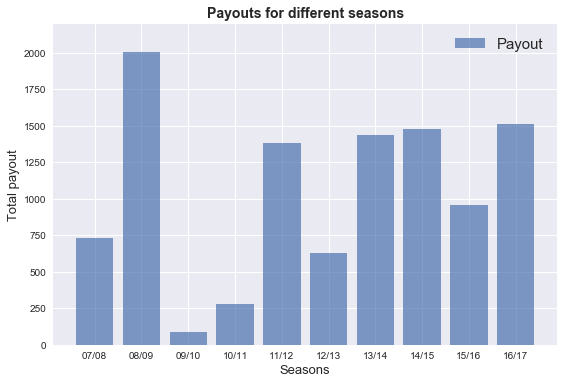

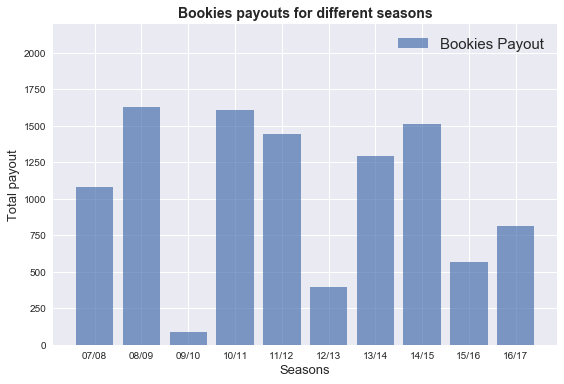

In [272]:
payouts = []
bookies_payouts = []
x = 1000

for i in range(708,1718,101):
    if i < 1011:
        simu = simulate('0'+str(i),x)
        payouts.append(simu[0])
        bookies_payouts.append(simu[1])
    else:
        simu = simulate(str(i),x)
        payouts.append(simu[0])
        bookies_payouts.append(simu[1])

print()
print("Total payout over 10 seasons is: {}".format(np.sum(payouts)-(x*len(payouts))))
print("This is {}%".format(((np.sum(payouts)-(x*len(payouts)))*100)/(x*len(payouts))))
print()
print("Total bookies payout over 10 seasons is: {}".format(np.sum(bookies_payouts)-(x*len(bookies_payouts))))
print("This is {}%".format(((np.sum(bookies_payouts)-(x*len(bookies_payouts)))*100)/(x*len(bookies_payouts))))

x = np.arange(10)
plt.bar(x, height= payouts, label='Payout', alpha=0.7)
plt.xticks(x, ['07/08','08/09','09/10','10/11','11/12','12/13','13/14','14/15','15/16','16/17']);
plt.legend(loc='upper right', fontsize=15)
plt.xlabel("Seasons",size=13)
plt.ylabel("Total payout",size=13)
plt.title("Payouts for different seasons",size=14,fontweight='bold')
plt.tight_layout()
plt.ylim(0,2200)
plt.show()

x = np.arange(10)
plt.bar(x, height= bookies_payouts, label='Bookies Payout', alpha=0.7)
plt.xticks(x, ['07/08','08/09','09/10','10/11','11/12','12/13','13/14','14/15','15/16','16/17']);
plt.legend(loc='upper right', fontsize=15)
plt.xlabel("Seasons",size=13)
plt.ylabel("Total payout",size=13)
plt.title("Bookies payouts for different seasons",size=14,fontweight='bold')
plt.tight_layout()
plt.ylim(0,2200)
plt.show()


## Accuracy Comparison


Model mean accuracy $ \frac{(66.67+100+50+50+100+66.67+100+100+75+100)}{10}=80.8\% $

Model total accuracy $ = \frac{\text{# of correct bets}*100}{\text{# of total bets}} =  \frac{37*100}{47}=78.72\% $

$ $


Bookies mean accuracy $ \frac{(80+100+50+100+100+57.14+100+100+60+80)}{10} = 82.71\% $


Bookies total accuracy $ = \frac{\text{# of correct bets}*100}{\text{# of total bets}} =  \frac{34*100}{44}=77.27\% $

## Simulation of the last 20 games of each season in the last 10 years

In [289]:
def simulate2(season, x):
    
    epl = pd.read_csv("http://www.football-data.co.uk/mmz4281/{}/E0.csv".format(season))
    epl = epl[['HomeTeam','AwayTeam','FTHG','FTAG', 'FTR', 'B365H', 'B365A']]
    epl = epl.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals' , 'FTR' : 'Winner'})
    goal_model_data = pd.concat([epl[['HomeTeam','AwayTeam','HomeGoals']].assign(home=1).rename(
            columns={'HomeTeam':'team', 'AwayTeam':'opponent','HomeGoals':'goals'}),
           epl[['AwayTeam','HomeTeam','AwayGoals']].assign(home=0).rename(
            columns={'AwayTeam':'team', 'HomeTeam':'opponent','AwayGoals':'goals'})])

    poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data, 
                            family=sm.families.Poisson()).fit()
    
    epl_matches = epl[['HomeTeam','AwayTeam']]
    epl_matches = epl_matches[-20:]
    epl_winner = epl[['Winner']]
    epl_odds = epl[['B365H', 'B365A']]

    #model lists
    bets = []
    results = []
    odds = []
    
    #bookies litst
    bookies_bets = []
    bookies_results = []
    bookies_odds = []
    
    #initial values
    payout = 0
    bookies_payout = 0
    model_wins = 0
    bookies_wins = 0
    
    for i in range(361,380):
        matrix = simulate_match(poisson_model, epl_matches['HomeTeam'][i], epl_matches['AwayTeam'][i], max_goals=10)
        home_win = np.sum(np.tril(matrix, -1))
        draw = np.sum(np.diag(matrix))
        away_win = np.sum(np.triu(matrix, 1))
        if home_win > 0.55:
            bets.append('H')
            results.append(epl_winner['Winner'][i])
            odds.append((float)(epl_odds['B365H'][i]))
        elif away_win > 0.55:
            bets.append('A')
            results.append(epl_winner['Winner'][i])
            odds.append((float)(epl_odds['B365A'][i]))
        if 1/epl_odds['B365H'][i] > 0.55:
            bookies_bets.append('H')
            bookies_results.append(epl_winner['Winner'][i])
            bookies_odds.append((float)(epl_odds['B365H'][i]))
        elif 1/epl_odds['B365A'][i] > 0.55:
            bookies_bets.append('A')
            bookies_results.append(epl_winner['Winner'][i])
            bookies_odds.append((float)(epl_odds['B365A'][i]))

    model_acc = 0
    bookies_acc = 0
    
    for k in range(0, len(bets)):
        if bets[k] == results[k]:
            payout += (odds[k]*(x/len(bets)))
            model_acc +=1
        else:
            payout -= x/len(bets)
            
    for m in range(0, len(bookies_bets)):       
        if bookies_bets[m] == bookies_results[m]:
            bookies_payout += (bookies_odds[m]*(x/len(bookies_bets)))
            bookies_acc += 1
        else:
            bookies_payout -= x/len(bookies_bets)
        
    print()
    print(season)
    print("Model bets: {}".format(bets))
    print("Actual results: {}".format(results))
    print("Model accuracy: {}%".format((model_acc*100)/len(bets)))
    print()
    print("Bookies results: {}".format(bookies_bets))
    print("Bookies results: {}".format(bookies_results))
    print("Bookies accuracy: {}%".format((bookies_acc*100)/len(bookies_bets)))
    
    return [payout, bookies_payout]


0708
Model bets: ['H', 'H', 'H', 'A', 'H', 'A', 'H', 'H', 'A', 'A']
Actual results: ['H', 'H', 'H', 'A', 'D', 'A', 'H', 'A', 'A', 'A']
Model accuracy: 80.0%

Bookies results: ['H', 'H', 'H', 'H', 'H', 'A', 'H', 'A', 'H', 'A', 'A']
Bookies results: ['H', 'H', 'H', 'H', 'H', 'A', 'D', 'A', 'H', 'A', 'A']
Bookies accuracy: 90.9090909090909%

0809
Model bets: ['H', 'H', 'H', 'A', 'H', 'H', 'A', 'H', 'H', 'A', 'H']
Actual results: ['H', 'D', 'H', 'A', 'H', 'H', 'A', 'H', 'H', 'A', 'H']
Model accuracy: 90.9090909090909%

Bookies results: ['H', 'H', 'H', 'A', 'H', 'H', 'H']
Bookies results: ['H', 'D', 'H', 'A', 'H', 'H', 'H']
Bookies accuracy: 85.71428571428571%

0910
Model bets: ['H', 'A', 'H', 'H', 'A', 'H', 'H', 'A', 'H']
Actual results: ['H', 'A', 'H', 'A', 'H', 'H', 'H', 'D', 'H']
Model accuracy: 66.66666666666667%

Bookies results: ['H', 'A', 'H', 'H', 'H', 'A', 'H', 'H', 'A', 'H']
Bookies results: ['H', 'A', 'D', 'H', 'A', 'H', 'H', 'H', 'D', 'H']
Bookies accuracy: 60.0%

1011
Model b

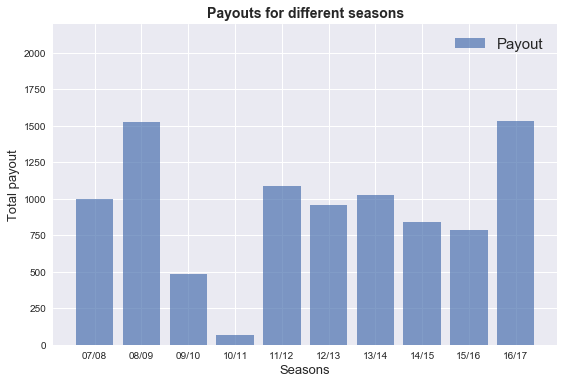

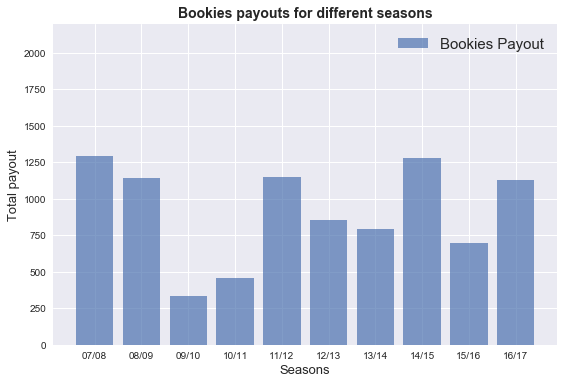

In [290]:
payouts = []
bookies_payouts = []
x = 1000

for i in range(708,1718,101):
    if i < 1011:
        simu = simulate2('0'+str(i),x)
        payouts.append(simu[0])
        bookies_payouts.append(simu[1])
    else:
        simu = simulate2(str(i),x)
        payouts.append(simu[0])
        bookies_payouts.append(simu[1])

print("Total payout over 10 seasons is: {}".format(np.sum(payouts)-(x*len(payouts))))
print("This is {}%".format(((np.sum(payouts)-(x*len(payouts)))*100)/(x*len(payouts))))

print("Total bookies payout over 10 seasons is: {}".format(np.sum(bookies_payouts)-(x*len(bookies_payouts))))
print("This is {}%".format(((np.sum(bookies_payouts)-(x*len(bookies_payouts)))*100)/(x*len(bookies_payouts))))

x = np.arange(10)
plt.bar(x, height= payouts, label='Payout', alpha=0.7)
plt.xticks(x, ['07/08','08/09','09/10','10/11','11/12','12/13','13/14','14/15','15/16','16/17']);
plt.legend(loc='upper right', fontsize=15)
plt.xlabel("Seasons",size=13)
plt.ylabel("Total payout",size=13)
plt.title("Payouts for different seasons",size=14,fontweight='bold')
plt.tight_layout()
plt.ylim(0,2200)
plt.show()

x = np.arange(10)
plt.bar(x, height= bookies_payouts, label='Bookies Payout', alpha=0.7)
plt.xticks(x, ['07/08','08/09','09/10','10/11','11/12','12/13','13/14','14/15','15/16','16/17']);
plt.legend(loc='upper right', fontsize=15)
plt.xlabel("Seasons",size=13)
plt.ylabel("Total payout",size=13)
plt.title("Bookies payouts for different seasons",size=14,fontweight='bold')
plt.tight_layout()
plt.ylim(0,2200)
plt.show()

## Accuracy Comparison

Model total accuracy $ = \frac{\text{# of correct bets}*100}{\text{# of total bets}} =  \frac{73*100}{92}=79.35\% $

Bookies total accuracy $ = \frac{\text{# of correct bets}*100}{\text{# of total bets}} =  \frac{73*100}{93}=78.49\% $

## Bookis bet when Model bets

In the following simulations I will make the bookies bet every time the model wants to bet

In [283]:
def simulate4(season, x):
    
    epl = pd.read_csv("http://www.football-data.co.uk/mmz4281/{}/E0.csv".format(season))
    epl = epl[['HomeTeam','AwayTeam','FTHG','FTAG', 'FTR', 'B365H', 'B365A']]
    epl = epl.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals' , 'FTR' : 'Winner'})
    goal_model_data = pd.concat([epl[['HomeTeam','AwayTeam','HomeGoals']].assign(home=1).rename(
            columns={'HomeTeam':'team', 'AwayTeam':'opponent','HomeGoals':'goals'}),
           epl[['AwayTeam','HomeTeam','AwayGoals']].assign(home=0).rename(
            columns={'AwayTeam':'team', 'HomeTeam':'opponent','AwayGoals':'goals'})])

    poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data, 
                            family=sm.families.Poisson()).fit()
    
    epl_matches = epl[['HomeTeam','AwayTeam']]
    epl_matches = epl_matches[-10:]
    epl_winner = epl[['Winner']]
    epl_odds = epl[['B365H', 'B365A']]

    #model lists
    bets = []
    results = []
    odds = []
    
    #bookies litst
    bookies_bets = []
    bookies_results = []
    bookies_odds = []
    
    #initial values
    payout = 0
    bookies_payout = 0
    model_wins = 0
    bookies_wins = 0
    
    for i in range(371,380):
        matrix = simulate_match(poisson_model, epl_matches['HomeTeam'][i], epl_matches['AwayTeam'][i], max_goals=10)
        home_win = np.sum(np.tril(matrix, -1))
        draw = np.sum(np.diag(matrix))
        away_win = np.sum(np.triu(matrix, 1))
        if home_win > 0.55:
            bets.append('H')
            results.append(epl_winner['Winner'][i])
            odds.append((float)(epl_odds['B365H'][i]))
            if (1/epl_odds['B365H'][i]) > (1/epl_odds['B365A'][i]):
                bookies_bets.append('H')
                bookies_results.append(epl_winner['Winner'][i])
                bookies_odds.append((float)(epl_odds['B365H'][i]))
            else:
                bookies_bets.append('A')
                bookies_results.append(epl_winner['Winner'][i])
                bookies_odds.append((float)(epl_odds['B365A'][i]))
            
        elif away_win > 0.55:
            bets.append('A')
            results.append(epl_winner['Winner'][i])
            odds.append((float)(epl_odds['B365A'][i]))
            if epl_odds['B365H'][i] > epl_odds['B365A'][i]:
                bookies_bets.append('H')
                bookies_results.append(epl_winner['Winner'][i])
                bookies_odds.append((float)(epl_odds['B365H'][i]))
            else:
                bookies_bets.append('A')
                bookies_results.append(epl_winner['Winner'][i])
                bookies_odds.append((float)(epl_odds['B365A'][i]))
     
    model_acc = 0
    bookies_acc = 0
    
    for k in range(0, len(bets)):
        if bets[k] == results[k]:
            payout += (odds[k]*(x/len(bets)))
            model_acc += 1
            if bookies_bets[k] != results[k]:
                model_wins += 1
        elif bets[k] != results[k]:
            payout -= x/len(bets)
            if bookies_bets[k] == results[k]:
                bookies_wins += 1
        if bookies_bets[k] == bookies_results[k]:
            bookies_acc += 1
            bookies_payout += (bookies_odds[k]*(x/len(bookies_bets)))
        elif bookies_bets[k] != bookies_results[k]:
            bookies_payout -= x/len(bookies_bets)
        
    print()
    print()
    print(season)
    print("Model bets: {}".format(bets))
    print("Actual results: {}".format(results))
    print("Model accuracy: {}%".format((model_acc*100)/len(bets)))
    print("Model predicted right outcome when Bookies predicted wrong outcome in season {}: {}".format(season,model_wins))
    print()
    print("Bookies bets: {}".format(bookies_bets))
    print("Actual results: {}".format(bookies_results))
    print("Bookies accuracy: {}%".format((bookies_acc*100)/len(bookies_bets)))
    print("Bookies predicted right outcome when Model predicted wrong outcome in season {}: {}".format(season,bookies_wins))
    
    return [payout, bookies_payout]



0708
Model bets: ['H', 'A', 'H', 'H', 'A', 'A']
Actual results: ['D', 'A', 'H', 'A', 'A', 'A']
Model accuracy: 66.66666666666667%
Model predicted right outcome when Bookies predicted wrong outcome in season 0708: 3

Bookies bets: ['H', 'H', 'H', 'A', 'H', 'H']
Actual results: ['D', 'A', 'H', 'A', 'A', 'A']
Bookies accuracy: 33.333333333333336%
Bookies predicted right outcome when Model predicted wrong outcome in season 0708: 1


0809
Model bets: ['H', 'A', 'H', 'H', 'A', 'H']
Actual results: ['H', 'A', 'H', 'H', 'A', 'H']
Model accuracy: 100.0%
Model predicted right outcome when Bookies predicted wrong outcome in season 0809: 2

Bookies bets: ['H', 'H', 'H', 'H', 'H', 'H']
Actual results: ['H', 'A', 'H', 'H', 'A', 'H']
Bookies accuracy: 66.66666666666667%
Bookies predicted right outcome when Model predicted wrong outcome in season 0809: 0


0910
Model bets: ['H', 'A', 'H', 'H', 'A', 'H']
Actual results: ['A', 'H', 'H', 'H', 'D', 'H']
Model accuracy: 50.0%
Model predicted right outcom

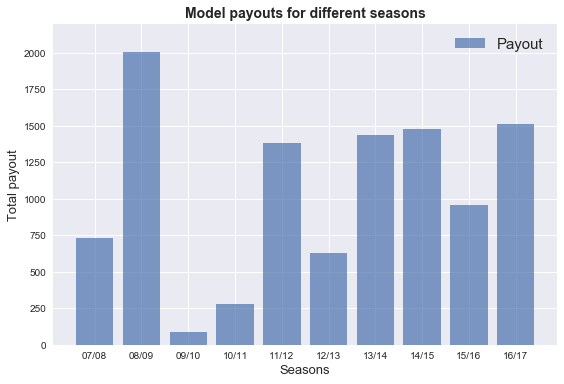

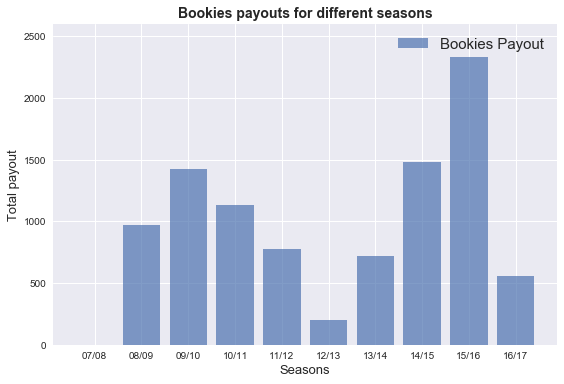

In [284]:
payouts = []
bookies_payouts = []
x = 1000

for i in range(708,1718,101):
    if i < 1011:
        simu = simulate4('0'+str(i),x)
        payouts.append(simu[0])
        bookies_payouts.append(simu[1])
    else:
        simu = simulate4(str(i),x)
        payouts.append(simu[0])
        bookies_payouts.append(simu[1])

print()
print("Total payout over 10 seasons is: {}".format(np.sum(payouts)-(x*len(payouts))))
print("This is {}%".format(((np.sum(payouts)-(x*len(payouts)))*100)/(x*len(payouts))))
print()
print("Total bookies payout over 10 seasons is: {}".format(np.sum(bookies_payouts)-(x*len(bookies_payouts))))
print("This is {}%".format(((np.sum(bookies_payouts)-(x*len(bookies_payouts)))*100)/(x*len(bookies_payouts))))

x = np.arange(10)
plt.bar(x, height= payouts, label='Payout', alpha=0.7)
plt.xticks(x, ['07/08','08/09','09/10','10/11','11/12','12/13','13/14','14/15','15/16','16/17']);
plt.legend(loc='upper right', fontsize=15)
plt.xlabel("Seasons",size=13)
plt.ylabel("Total payout",size=13)
plt.title("Model payouts for different seasons",size=14,fontweight='bold')
plt.tight_layout()
plt.ylim(0,2200)
plt.show()

x = np.arange(10)
plt.bar(x, height= bookies_payouts, label='Bookies Payout', alpha=0.7)
plt.xticks(x, ['07/08','08/09','09/10','10/11','11/12','12/13','13/14','14/15','15/16','16/17']);
plt.legend(loc='upper right', fontsize=15)
plt.xlabel("Seasons",size=13)
plt.ylabel("Total payout",size=13)
plt.title("Bookies payouts for different seasons",size=14,fontweight='bold')
plt.tight_layout()
plt.ylim(0,2600)
plt.show()

Accuracy Comparison:

Score Model vs Bookies: 10:4

Model mean accuracy $ = \frac{(66.67+100+50+50+100+66.67+100+100+75+100)}{10}=80.8\% $

Model total accuracy $ = \frac{\text{# of correct bets}*100}{\text{# of total bets}} =  \frac{37*100}{47}=78.72\% $

$ $


Bookies mean accuracy $ = \frac{(33.33+66.67+66.67+75+75+50+75+100+100+60)}{10}=70.16\% $

Bookies total accuracy $ = \frac{\text{# of correct bets}*100}{\text{# of total bets}} =  \frac{31*100}{47}=65.96\% $

## Including bookies' odds to back up the model's predictions

In [285]:
def simulate5(season, x, p):
    
    epl = pd.read_csv("http://www.football-data.co.uk/mmz4281/{}/E0.csv".format(season))
    epl = epl[['HomeTeam','AwayTeam','FTHG','FTAG', 'FTR', 'B365H', 'B365A' , 'B365D']]
    epl = epl.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals' , 'FTR' : 'Winner'})
    goal_model_data = pd.concat([epl[['HomeTeam','AwayTeam','HomeGoals']].assign(home=1).rename(
            columns={'HomeTeam':'team', 'AwayTeam':'opponent','HomeGoals':'goals'}),
           epl[['AwayTeam','HomeTeam','AwayGoals']].assign(home=0).rename(
            columns={'AwayTeam':'team', 'HomeTeam':'opponent','AwayGoals':'goals'})])

    poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data, 
                            family=sm.families.Poisson()).fit()
    
    epl_matches = epl[['HomeTeam','AwayTeam']]
    epl_matches = epl_matches[-10:]
    epl_winner = epl[['Winner']]
    epl_odds = epl[['B365H', 'B365A', 'B365D']]

    #model lists
    bets = []
    results = []
    odds = []
    
    #initial values
    payout = 0
    
    for i in range(371,380):
        matrix = simulate_match(poisson_model, epl_matches['HomeTeam'][i], epl_matches['AwayTeam'][i], max_goals=10)
        home_win = np.sum(np.tril(matrix, -1))
        draw = np.sum(np.diag(matrix))
        away_win = np.sum(np.triu(matrix, 1))
        
        #If bookies predict a high probability of a draw or a different winner than the model it will be adjusted
        if ((1/epl_odds['B365A'][i]) > .35 or (1/epl_odds['B365D'][i]) > 0.2):
            home_win = home_win - p*(((1/epl_odds['B365A'][i])+(1/epl_odds['B365D'][i]))/2)
        elif((1/epl_odds['B365A'][i]) > .55 or (1/epl_odds['B365D'][i]) < 0.2):
            away_win = away_win + p*(((1/epl_odds['B365A'][i])+(1/epl_odds['B365D'][i]))/2)
        elif ((1/epl_odds['B365H'][i]) > .35 or (1/epl_odds['B365D'][i]) > 0.2):
            away_win = away_win - p*(((1/epl_odds['B365H'][i])+(1/epl_odds['B365D'][i]))/2)
        elif((1/epl_odds['B365H'][i]) > .55 or (1/epl_odds['B365D'][i]) < 0.2):
            home_win = home_win + p*(((1/epl_odds['B365H'][i])+(1/epl_odds['B365D'][i]))/2)
            
        if home_win > 0.55:
            bets.append('H')
            results.append(epl_winner['Winner'][i])
            odds.append((float)(epl_odds['B365H'][i]))
            
        elif away_win > 0.55:
            bets.append('A')
            results.append(epl_winner['Winner'][i])
            odds.append((float)(epl_odds['B365A'][i]))
            

    accr = 0
    for k in range(0, len(bets)):
        if bets[k] == results[k]:
            payout += ((odds[k]*(x/len(bets))))
            accr += 1
        elif bets[k] != results[k]:
            payout -= x/len(bets)
        
        
    print(season)
    print("Model bets: {}".format(bets))
    print("Actual results: {}".format(results))
    print(payout)
    print("Accuracy: {}%".format((accr*100)/len(bets)))
    print()
    
    return payout

0708
Model bets: ['H', 'A', 'H', 'A', 'A']
Actual results: ['D', 'A', 'H', 'A', 'A']
1078.0
Accuracy: 80.0%

0809
Model bets: ['H', 'A', 'H', 'A']
Actual results: ['H', 'A', 'H', 'A']
2010.0
Accuracy: 100.0%

0910
Model bets: ['H', 'A', 'H', 'H', 'A', 'H']
Actual results: ['A', 'H', 'H', 'H', 'D', 'H']
86.66666666666669
Accuracy: 50.0%

1011
Model bets: ['H', 'H']
Actual results: ['H', 'H']
1565.0
Accuracy: 100.0%

1112
Model bets: ['H', 'A', 'H']
Actual results: ['H', 'A', 'H']
1323.333333333333
Accuracy: 100.0%

1213
Model bets: ['H', 'H', 'A', 'H', 'A']
Actual results: ['H', 'A', 'A', 'H', 'D']
418.0
Accuracy: 60.0%

1314
Model bets: ['H', 'H', 'A', 'H']
Actual results: ['H', 'H', 'A', 'H']
1435.0
Accuracy: 100.0%

1415
Model bets: ['H', 'H']
Actual results: ['H', 'H']
1480.0
Accuracy: 100.0%

1516
Model bets: ['H', 'A', 'H', 'H']
Actual results: ['H', 'H', 'H', 'H']
957.5
Accuracy: 75.0%

1617
Model bets: ['H', 'A', 'H', 'H', 'A']
Actual results: ['H', 'A', 'H', 'H', 'A']
1516.0
Ac

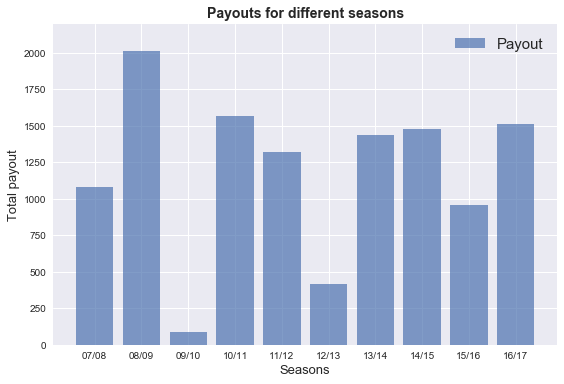

In [286]:
payouts = []
x = 1000
p = 0.2

for i in range(708,1718,101):
    if i < 1011:
        simu = simulate5('0'+str(i),x,p)
        payouts.append(simu)
    else:
        simu = simulate5(str(i),x,p)
        payouts.append(simu)

print("Total payout over 10 seasons is: {}".format(np.sum(payouts)-(x*len(payouts))))
print("This is {}%".format(((np.sum(payouts)-(x*len(payouts)))*100)/(x*len(payouts))))

x = np.arange(10)
plt.bar(x, height= payouts, label='Payout', alpha=0.7)
plt.xticks(x, ['07/08','08/09','09/10','10/11','11/12','12/13','13/14','14/15','15/16','16/17']);
plt.legend(loc='upper right', fontsize=15)
plt.xlabel("Seasons",size=13)
plt.ylabel("Total payout",size=13)
plt.title("Payouts for different seasons",size=14,fontweight='bold')
plt.tight_layout()
plt.ylim(0,2200)
plt.show()

## Mean accuracy of Model over 10 seasons:

Model mean accuracy $ = \frac{(80+100+50+100+100+60+100+100+75+100)}{10} = 86.5\% $

Model total accuracy $ = \frac{\text{# of correct bets}*100}{\text{# of total bets}} =  \frac{33*100}{40}=82.5\% $

$ $


Bookies mean accuracy: $ \frac{(80+100+50+100+100+57.14+100+100+60+80)}{10} = 82.71\% $


Bookies total accuracy $ = \frac{\text{# of correct bets}*100}{\text{# of total bets}} =  \frac{34*100}{44}=77.27\% $

## Weaknesses of the model

- assumption of Poisson Distribution might not hold true
    - initial Poisson Distribution has mean $ \lambda $
    - then half the time should follow a Poisson Distribution with $ \frac{\lambda}{2} $


In [236]:
epl_1617_halves = pd.read_csv("http://www.football-data.co.uk/mmz4281/1617/E0.csv")
epl_1617_halves = epl_1617_halves[['FTHG', 'FTAG', 'HTHG', 'HTAG']]
epl_1617_halves['FHgoals'] = epl_1617_halves['HTHG'] + epl_1617_halves['HTAG']
epl_1617_halves['SHgoals'] = epl_1617_halves['FTHG'] + epl_1617_halves['FTAG'] - epl_1617_halves['FHgoals']
epl_1617_halves = epl_1617_halves[['FHgoals', 'SHgoals']]
epl_1617_halves.mean()

FHgoals    1.215789
SHgoals    1.584211
dtype: float64

- for Poisson Distribution mean = variance

In [237]:
print(epl_1617.mean())
print(epl_1617.var())

HomeGoals    1.636364
AwayGoals    1.187879
dtype: float64
HomeGoals    1.672838
AwayGoals    1.350613
dtype: float64


- limits use of data to only one season


## Prediction of the next game day in the current season 11/25/17 11/26/17

In [213]:
epl = pd.read_csv("http://www.football-data.co.uk/mmz4281/1718/E0.csv")
epl = epl[['HomeTeam','AwayTeam','FTHG','FTAG', 'FTR', 'B365H', 'B365A' , 'B365D']]
epl = epl.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals' , 'FTR' : 'Winner'})
goal_model_data = pd.concat([epl[['HomeTeam','AwayTeam','HomeGoals']].assign(home=1).rename(
        columns={'HomeTeam':'team', 'AwayTeam':'opponent','HomeGoals':'goals'}),
        epl[['AwayTeam','HomeTeam','AwayGoals']].assign(home=0).rename(
        columns={'AwayTeam':'team', 'HomeTeam':'opponent','AwayGoals':'goals'})])

poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data, 
                        family=sm.families.Poisson()).fit()

home_teams = ['Man United','Crystal Palace','Tottenham','Swansea','Newcastle','Liverpool','Southampton','Burnley','Huddersfield']
away_teams = ['Brighton','Stoke','West Brom','Bournemouth','Watford','Chelsea','Everton','Arsenal','Man City']

#odds from: https://www.oddschecker.com/football/english/premier-league
home_win_odds = [2/9,13/12,3/11,24/13,23/18,6/5,10/11,21/4,17/1]
draw_odds = [32/5,53/21,21/4,23/10,5/2,27/10,5/2,7/2,71/10]
away_win_odds = [20/1,3/1,15/1,11/6,5/2,28/11,4/1,10/17,3/14]

money = 100
bets = {}
max_return = 0
p = 0.2

for i in range(0,9):
    matrix = simulate_match(poisson_model, home_teams[i], away_teams[i], max_goals=10)
    home_win = np.sum(np.tril(matrix, -1))
    draw = np.sum(np.diag(matrix))
    away_win = np.sum(np.triu(matrix, 1))

    #If bookies predict a high probability of a draw or a different winner than the model it will be adjusted
    if ((1/away_win_odds[i]) > .35 or (1/draw_odds[i]) > 0.2):
        home_win = home_win - p*(((1/away_win_odds[i])+(1/draw_odds[i]))/2)
    elif((1/away_win_odds[i]) > .55 or (1/draw_odds[i]) < 0.2):
        away_win = away_win + p*(((1/away_win_odds[i])+(1/draw_odds[i]))/2)
    elif ((1/home_win_odds[i]) > .35 or (1/draw_odds[i]) > 0.2):
        away_win = away_win - p*(((1/home_win_odds[i])+(1/draw_odds[i]))/2)
    elif((1/home_win_odds[i]) > .55 or (1/draw_odds[i]) < 0.2):
        home_win = home_win + p*(((1/home_win_odds[i])+(1/draw_odds[i]))/2)
    
    if home_win > 0.6:
        bets[home_teams[i]] = home_win
        max_return += money + (money*home_win_odds[i])

    elif away_win > 0.6:
        bets[away_teams[i]] = away_win
        max_return += money + (money*away_win_odds[i])

print(bets)
print('maximum return: {}'.format(max_return))
print('maximum win {}'.format(max_return-(money*len(bets))))
print('maximum win in %: {}'.format(((max_return-(money*len(bets)))/max_return)*100))


{'Man United': 0.74528628521404383, 'Tottenham': 0.77350895203001568, 'Man City': 0.93708863046207691}
maximum return: 370.9235209235209
maximum win 70.92352092352093
maximum win in %: 19.120793619918306


Manchester United: W, Tottenham: D, Manchester City: W 

## Looking for Arbitrage - NOT PART OF PROJECT JUST INTERESTING

In [208]:
epl = pd.read_csv("http://www.football-data.co.uk/mmz4281/1617/E0.csv")
home_win_odds = epl[['B365H','BWH','IWH','LBH','PSH','VCH','WHH']]
draw_odds = epl[['B365D','BWD','IWD','LBD','PSD','VCD','WHD']]
away_win_odds = epl[['B365A','BWA','IWA','LBA','PSA','VCA','WHA']]

h_odds = []
d_odds = []
a_odds = []
arbi_op = 0

for h,d,a in zip(home_win_odds,draw_odds,away_win_odds):
    h_odds.append(home_win_odds[h])
    d_odds.append(draw_odds[d])
    a_odds.append(away_win_odds[a])
    
#print(len(h_odds))

for home in h_odds:
    print(home)
    for draw in d_odds:
        for away in a_odds:
            for i in range(0,len(home)):
                if ((1/float(home[i]))+(1/float(draw[i]))+(1/float(away[i]))) < 1:
                    arbi_op += 1
                    print('home: {}'.format(home[i]))
                    print('draw: {}'.format(draw[i]))
                    print('away: {}'.format(away[i]))
                    print((1/float(home[i]))+(1/float(draw[i]))+(1/float(away[i])))
print(arbi_op)
print(h_odds)
print(home_win_odds['B365H'])
        

0       2.40
1       2.00
2       3.20
3       4.50
4       1.25
5       2.38
6       1.80
7       2.40
8       4.75
9       1.65
10      1.53
11      6.50
12      2.88
13      5.50
14      1.80
15      1.45
16      5.50
17      3.00
18      2.55
19      1.95
20      1.25
21      2.30
22      1.73
23      8.00
24      1.73
25      1.57
26      2.38
27      5.00
28      1.25
29      2.60
       ...  
350     2.80
351     1.91
352     1.62
353     1.17
354     3.60
355     1.50
356    10.00
357     1.91
358     1.25
359     4.00
360     4.75
361     4.20
362     2.10
363     1.73
364     5.25
365     1.25
366     1.09
367     1.14
368     2.75
369     4.50
370     1.45
371     2.45
372     1.14
373     7.00
374     2.00
375     1.14
376     2.50
377     1.80
378     2.10
379    11.00
Name: B365H, Length: 380, dtype: float64
home: 4.5
draw: 3.6
away: 2.1
0.9761904761904762
home: 3.1
draw: 3.3
away: 2.7
0.9959813185619637
home: 3.5
draw: 3.5
away: 2.4
0.9880952380952381
home: 3.5
draw: 3.3

draw: 4.2
away: 5.88
0.9963985594237694
home: 2.3
draw: 3.5
away: 3.7
0.9907671646802081
home: 2.2
draw: 3.3
away: 4.2
0.9956709956709957
home: 1.3
draw: 6.5
away: 14.0
0.9945054945054944
home: 5.0
draw: 3.9
away: 1.85
0.9969507969507969
home: 2.1
draw: 3.7
away: 4.22
0.9834275711052962
home: 1.85
draw: 3.9
away: 5.35
0.9838666848012643
home: 1.33
draw: 6.75
away: 13.5
0.9741019214703425
home: 1.2
draw: 9.0
away: 21.02
0.9920181837403531
home: 1.6
draw: 4.33
away: 8.5
0.9735939410406195
home: 4.1
draw: 3.5
away: 2.15
0.9947330038084434
home: 3.35
draw: 3.5
away: 2.5
0.9842217484008529
home: 2.1
draw: 3.6
away: 4.3
0.9865263935031376
home: 3.8
draw: 3.6
away: 2.3
0.9757182812102722
home: 1.65
draw: 4.5
away: 7.0
0.9711399711399711
home: 1.7
draw: 4.0
away: 6.5
0.9920814479638009
home: 2.0
draw: 3.5
away: 4.75
0.9962406015037594
home: 2.0
draw: 3.5
away: 5.2
0.978021978021978
home: 2.1
draw: 3.6
away: 4.3
0.9865263935031376
home: 1.45
draw: 5.25
away: 8.5
0.997778421713513
home: 1.3
draw

home: 3.4
draw: 3.3
away: 2.5
0.9971479500891266
home: 2.2
draw: 3.5
away: 4.1
0.9841621792841304
home: 4.5
draw: 3.5
away: 2.1
0.9841269841269841
home: 3.4
draw: 3.3
away: 2.5
0.9971479500891266
home: 4.33
draw: 3.8
away: 2.0
0.9941047769539322
home: 1.29
draw: 6.35
away: 15.0
0.999340780076909
home: 4.5
draw: 3.55
away: 2.1
0.9801028392577688
home: 6.0
draw: 3.87
away: 1.75
0.9964931709117755
home: 3.4
draw: 3.37
away: 2.5
0.9908535521033339
home: 7.5
draw: 4.59
away: 1.55
0.9963595474031907
home: 4.33
draw: 3.78
away: 2.0
0.9954971467673547
home: 6.5
draw: 4.61
away: 1.6
0.9957658935424663
home: 2.6
draw: 3.4
away: 3.14
0.9972043692538259
home: 1.29
draw: 6.35
away: 15.0
0.999340780076909
home: 6.0
draw: 3.94
away: 1.73
0.9985084553465763
home: 4.5
draw: 3.5
away: 2.1
0.9841269841269841
home: 3.4
draw: 3.4
away: 2.5
0.9882352941176471
home: 7.5
draw: 4.75
away: 1.55
0.9890209394453876
home: 4.33
draw: 3.8
away: 2.0
0.9941047769539322
home: 6.5
draw: 4.6
away: 1.6
0.9962374581939799


away: 9.0
0.9942348008385744
home: 2.3
draw: 3.5
away: 3.6
0.9982746721877157
home: 1.55
draw: 4.4
away: 8.0
0.9974340175953079
home: 3.4
draw: 3.3
away: 2.5
0.9971479500891266
home: 2.3
draw: 3.5
away: 4.1
0.9643993334343282
home: 2.1
draw: 3.4
away: 4.37
0.9991410751943797
home: 2.5
draw: 3.3
away: 3.43
0.9945754925346763
home: 2.3
draw: 3.5
away: 3.64
0.9952221691352126
home: 2.3
draw: 3.5
away: 3.6
0.9982746721877157
home: 6.25
draw: 4.0
away: 1.7
0.9982352941176471
home: 4.4
draw: 3.5
away: 2.1
0.9891774891774892
home: 5.75
draw: 3.75
away: 1.8
0.9961352657004832
home: 6.25
draw: 3.75
away: 1.75
0.998095238095238
home: 3.1
draw: 3.3
away: 2.7
0.9959813185619637
home: 3.4
draw: 3.3
away: 2.5
0.9971479500891266
home: 8.0
draw: 4.5
away: 1.55
0.9923835125448028
home: 2.3
draw: 3.25
away: 4.1
0.9863773554123502
home: 4.33
draw: 3.8
away: 2.0
0.9941047769539322
home: 3.25
draw: 3.43
away: 2.5
0.9992374971966809
home: 4.4
draw: 3.55
away: 2.1
0.9851533443082738
home: 5.75
draw: 3.74
awa